In [ ]:
DEVICE = 'cuda:0' 
config = {
    "embedding": 32, # Node embeddings size 
    "batch": 512, # Batch size 
    "epochs": 1000, # Training 
    "target": "seconds", # sat OR seconds (classification vs regression)
    "log": False, # Whether model should be trained in log-space 
    "dataset": "cnf.csv", # File with dataset
    "layers": 3, # Number of GNN layers 
    "transformation": "linear", # Node transformation before applying GNN (relu, linear, mlp)
    "gnn": "GINConv", # Actual graph network architecture (SAGEConv, SAGE_MLP, MLP_GIN, GINConv, GATConv, MLPGraphNorm)
    "projection": "linear", # How to combine neighbor embeddings (linear, mlp, mlp-3)
    "readout": "multi", # How to aggregate final node embeddings (lstm, mean, sum, multi)
    "dropout": True,
    "jumping": True, # Whether apply jumping knowledge technique (sum over past values) 
    "encoding": "lig",
    "small": False, # Use subset of training data
}

In [ ]:
from pysat.formula import CNF
from itertools import permutations 
import torch 
import pandas as pd 
from copy import deepcopy 
from tqdm import tqdm 
import matplotlib.pyplot as plt 
import numpy 

from torch_geometric.loader import DataLoader
from torch.nn import Sequential, ReLU, Linear 
import torch.nn.functional as F 

from torch_geometric.nn import MessagePassing
from torch_geometric.nn import HeteroConv, SAGEConv, GAT, GATConv, GINConv 
from torch_geometric.data import Data
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.aggr import MLPAggregation, LSTMAggregation, SumAggregation, MultiAggregation 
from torch_geometric.nn.models import MLP 
from torch_geometric.utils import degree
from torch import Tensor

import torchmetrics
from torch_geometric.nn import summary 
import time 
import os 
import random 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dataset class

In [3]:
# Read CNF file and transform to graph

In [ ]:
initial_literal_embedding = torch.ones(config['embedding']) 
initial_clause_embedding = torch.ones(config['embedding']) 

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [ ]:
def index_literal(l, n_vars):
    "Return index of the literal."
    # First go positives, then negatives. Ex. [1, 2, 3, -1, -2, -3] 
    return l-1 if l > 0 else (-l-1)+n_vars 

def lig_graph(filepath):
    # LIG encoding 
    cnf = CNF(from_file=filepath)
    n_vars = cnf.nv 
    edges = [] 
    for clause in cnf.clauses:
        for (x_i, x_j) in permutations(clause, r=2):
            x_i = index_literal(x_i, n_vars)
            x_j = index_literal(x_j, n_vars)
            edges.append((x_i, x_j))
    edges = list(set(edges)) # Remove duplicates 
    # Add links between literals of same variable
    edges.extend([(i, i+n_vars) for i in range(n_vars)])
    edges.extend([(i+n_vars, i) for i in range(n_vars)]) # Both directions 
    edges = torch.Tensor(edges).to(torch.int64).T 

    # 2 literals for each variable 
    x = initial_literal_embedding.repeat(n_vars*2, 1) # Initialize node embeddings to ones 
    
    return x, edges 

SAT are 4899, UNSAT are 4899
                         filename    seconds    sat
0  formulas/3sat_200-300/1786.cnf   2.160860  False
1  formulas/3sat_200-300/7113.cnf  15.589273  False
2  formulas/3sat_200-300/1570.cnf   0.821568   True
3  formulas/3sat_200-300/2053.cnf   4.809507  False
4  formulas/3sat_200-300/5305.cnf   0.705415   True


100%|██████████| 9798/9798 [00:46<00:00, 211.65it/s]

Total dataset has 9798 graphs


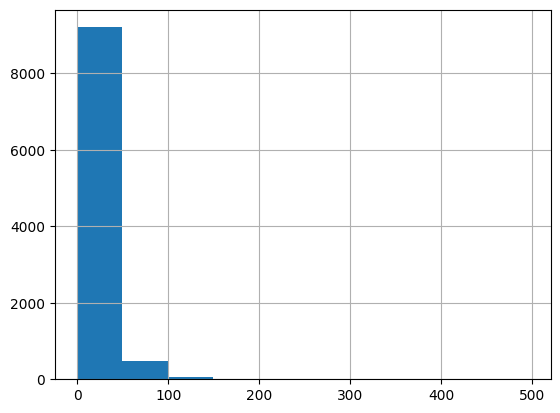

In [ ]:
formulas = pd.read_csv(config['dataset'])[['filename', 'seconds', 'sat']] 
formulas = formulas.sample(frac=1, random_state=12345).reset_index(drop=True) 

if config['small']:
    formulas = formulas[:2000] # Choose a subset 
print(f"SAT are {sum(formulas['sat'] == True)}, UNSAT are {sum(formulas['sat'] == False)}")


if config['log']:
    formulas['seconds'] = numpy.log(formulas['seconds'])  # log10
formulas['seconds'].hist() #bins=[0, 10, 100, 500]


mapping = {} 
dataset = [] 
batches = [] 
current_batch = [] 
for i, (file, seconds, sat) in enumerate(tqdm(formulas.values)):  
    x, edges = lig_graph(file) 
    data = Data(x=x, edge_index=edges) 
    # Add graph label 
    if config['target'] == "sat":
        data.y = float(sat) 
    else:
        data.y = seconds 
    data.validate() # Throw error if graph is not valid 
    dataset.append(data) 
    mapping[i] = file 
print(f"Total dataset has {len(dataset)} graphs")

# GNN model class

## Layers

In [13]:
class MLPGraphConv(MessagePassing):
    def __init__(self, mlp, aggr='mean'):
        super().__init__(aggr=aggr)  # Aggregation can be 'mean', 'add', or 'max'
        # Define the MLP
        self.mlp = mlp 

    def forward(self, x, edge_index):
        # # Add self-loops to the edge index
        # edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        # Perform message passing
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        # Apply the MLP to the source node features
        return self.mlp(x_j)


class SAGE_MLP(SAGEConv):
    # Only apply MLP on node embedddings before message propagation 
    def __init__(self, mlp, *args, **kwargs):
        super().__init__(*args, **kwargs) 
        # Define the MLP
        self.mlp = deepcopy(mlp) 

    def message(self, x_j):
        # Apply the MLP to the source node features
        return self.mlp(x_j)


# With normalization 
class MLPGraphNorm(MessagePassing):
    def __init__(self, mlp, aggr='mean'):
        super(MLPGraphNorm, self).__init__(aggr=aggr)  # Aggregation can be 'mean', 'add', or 'max'
        # Define the MLP
        self.mlp = mlp

    def forward(self, x, edge_index):
        """
        Args:
            x: Node feature matrix or a tuple (x_src, x_dst) for bipartite graphs.
            edge_index: Edge index tensor.
        """
        if isinstance(x, tuple):
            x_src, x_dst = x
        elif isinstance(x, torch.Tensor):
            x_src = x_dst = x
        else:
            print("HERE", "STRANDE")
            print(type(x)) 
            print(x, x.shape)
            print(stange)

        # Number of source and target nodes
        num_src, num_dst = x_src.size(0), x_dst.size(0)
        
        # Compute degree for source nodes (row normalization)
        row, col = edge_index
        deg_src = degree(row, num_src, dtype=x_src.dtype)
        deg_inv_sqrt_src = deg_src.pow(-0.5)
        deg_inv_sqrt_src[deg_inv_sqrt_src == float('inf')] = 0

        # Compute degree for target nodes (col normalization)
        deg_dst = degree(col, num_dst, dtype=x_dst.dtype)
        deg_inv_sqrt_dst = deg_dst.pow(-0.5)
        deg_inv_sqrt_dst[deg_inv_sqrt_dst == float('inf')] = 0

        # Perform message passing
        return self.propagate(edge_index, x=(x_src, x_dst), 
                              deg_inv_sqrt_src=deg_inv_sqrt_src, 
                              deg_inv_sqrt_dst=deg_inv_sqrt_dst)

    def message(self, x_j, edge_index, deg_inv_sqrt_src, deg_inv_sqrt_dst):
        """
        Args:
            x_j: Features of source nodes.
            edge_index: Edge index tensor.
            deg_inv_sqrt_src: Normalization factor for source nodes.
            deg_inv_sqrt_dst: Normalization factor for target nodes.
        """
        row, col = edge_index
        norm = deg_inv_sqrt_src[row] * deg_inv_sqrt_dst[col]
        return norm.view(-1, 1) * self.mlp(x_j)

class MLP_GIN(GINConv):
    # Just GIN with MLP applied before message aggregation 
    def __init__(self, mlp, **kwargs):
        super().__init__(**kwargs)
        self.mlp = mlp 
    def message(self, x_j: Tensor) -> Tensor:
        return self.mlp(x_j) 

## Models

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        
        # Define convolution layers 
        self.convs = torch.nn.ModuleList() 
        for i in range(config['layers']):
            assert config['embedding'] == hidden_dim 

            match config['transformation']:
                case "relu":
                    node_mlp = Sequential(
                        Linear(hidden_dim, hidden_dim),
                        ReLU(),
                        Linear(hidden_dim, hidden_dim)
                    )
                case "linear":
                    node_mlp = Linear(hidden_dim, hidden_dim)
                case "mlp":
                    node_mlp = MLP(in_channels=hidden_dim, hidden_channels=hidden_dim, out_channels=hidden_dim, num_layers=3)  
                case _:
                    print(f"ERROR: '{config['transformation']}' is not defined as transformation operation.")
                    exit(1)
            
            # Used for GIN-based convolution 
            gin_nn = Sequential(
                Linear(hidden_dim, hidden_dim),
                ReLU(),
                Linear(hidden_dim, hidden_dim)
            )

            match config['gnn']:
                case "SAGEConv":
                    conv = SAGEConv(config['embedding'], hidden_dim, aggr='sum', project=False)
                case "SAGE_MLP":
                    conv = SAGE_MLP(node_mlp, config['embedding'], hidden_dim, aggr='sum', project=False)
                case "MLPGraphNorm":
                    conv = MLPGraphNorm(node_mlp, aggr='sum')
                case "MLP_GIN":
                    conv = MLP_GIN(node_mlp, nn=gin_nn, aggr='sum')
                case "GINConv":
                    conv = GINConv(nn=gin_nn, aggr='sum')
                case "GATConv":
                    conv = GATConv(config['embedding'], hidden_dim, add_self_loops=False) 
                case _:
                    print(f"ERROR: '{config['gnn']}' is not defined as GNN architecture.")
                    exit(1)
            self.convs.append(conv) 


        self.linears = torch.nn.ModuleList() 
        for i in range(config['layers']):
            match config["projection"]:
                case "linear":
                    # Linear layers for each node type
                    linear = torch.nn.Linear(hidden_dim, hidden_dim) # Concat of clause and opposite literal embeds 
                case "mlp":
                    linear = MLP([hidden_dim, hidden_dim, hidden_dim]) 
                case "mlp-3":
                    linear = MLP(in_channels=hidden_dim, hidden_channels=hidden_dim, out_channels=hidden_dim, num_layers=3)
                case _:
                    print(f"ERROR: '{config['projection']}' is not defined as projection operation.")
                    exit(1)
            self.linears.append(linear) 

        match config["readout"]:
            case "lstm":
                self.readout = LSTMAggregation(hidden_dim, hidden_dim, num_layers=3) 
            case "mean":
                self.readout = global_mean_pool 
            case "sum":
                self.readout = SumAggregation() 
            case "multi":
                self.readout = MultiAggregation(['sum', 'mean'], mode='cat') # cat is default mode
            case _:
                print(f"ERROR: '{config['readout']}' is not defined as readout operation.")
                exit(1)

        if config['target'] == "sat":
            # SAT classification 
            self.classifier = MLP([-1, hidden_dim, hidden_dim, 1]) 
        else:
            self.regressor = MLP(in_channels=-1, hidden_channels=hidden_dim, out_channels=1, num_layers=2) #MLP([hidden_dim, hidden_dim, 1]) # default activation is relu 

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch 

        # Apply heterogeneous message passing
        jumping_knowledge = torch.zeros(x.shape).to(x.device) 
        for conv, linear in zip(self.convs, self.linears):
            x = conv(x, edge_index) 
            x = x.relu() 
            x = linear(x)

            jumping_knowledge += x 

        # We'll aggregate over all nodes of the graph
        if config['jumping']:
            x_graph = self.readout(jumping_knowledge, batch) 
        else:
            x_graph = self.readout(x, batch) 

        if config['target'] == "sat":
            if config['dropout']:
                x_graph = F.dropout(x_graph, p=0.5, training=self.training) 
            res = torch.sigmoid(self.classifier(x_graph))
        else:            
            # Apply a final regressor
            if config['dropout']:
                x_graph = F.dropout(x_graph, p=0.5, training=self.training) # Dropout to avoid overfit
            res = self.regressor(x_graph) 
        
        return res 

# Training

In [15]:
test_split = len(dataset)*8//10 
# Create a DataLoader for batching
train_loader = DataLoader(dataset[:test_split], batch_size=config['batch'], shuffle=False) 
test_loader = DataLoader(dataset[test_split:], batch_size=config['batch'], shuffle=False) 

print(len(train_loader), len(test_loader))

16 4


In [ ]:
def train():
    model.train()

    for batch in train_loader:  # Iterate in batches over the training dataset.
        batch = batch.to(DEVICE) 
        out = model(batch).squeeze()  # Perform a single forward pass. 
        loss = criterion(out, batch.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        # Perform gradient clipping by value
        torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=5.) 
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    total_out = [] 
    total_y = [] 
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(DEVICE) 
            out = model(batch).squeeze() 
            total_out.append(out) 
            total_y.append(batch.y) 

    total_out = torch.cat(total_out, 0)
    total_y = torch.cat(total_y, 0)

    return total_out, total_y 

def compute_main_metric(out, y):
    total_loss = criterion(out, y) 
    return total_loss 

def compute_metrics(out, y):
    metrics = {} 
    if config['target'] == "sat": 
        metrics['Entropy'] = torch.nn.functional.binary_cross_entropy(out, y) 
        metrics['Accuracy'] = (torch.round(out) == y).sum() / len(out) # Count correct predictions 
    else: 
        metrics['MSE'] = torch.nn.functional.mse_loss(out, y) 
        metrics['L1'] = torch.nn.functional.l1_loss(out, y) 
        metrics['R2'] = torchmetrics.functional.r2_score(out, y) 
        metrics['MAPE'] = torchmetrics.functional.mean_absolute_percentage_error(out, y) 
        metrics['Spearman'] = torchmetrics.functional.spearman_corrcoef(out, y) 

    return metrics 

def plot_predictions(out, y, title='Test data', file=None):
    if config['target'] == "sat":
        disp = ConfusionMatrixDisplay.from_predictions(y.cpu(), out.cpu() > 0.5, normalize='true', display_labels=['UNSAT', 'SAT'], cmap=plt.cm.Blues)
        plt.title(title)
        if file:
            plt.savefig(file)
        else:
            plt.show() 
        
    else:
        # Regression task 
        fig, ax = plt.subplots(figsize=(5, 5)) 
        preds = out.cpu() 
        reals = y.cpu() 
        
        ax.set_xlim((0, 500.)) 
        ax.set_ylim((0, 500.))
        ax.set_aspect("equal")

        ax.set_title(title)
        ax.set_ylabel("Predictions")
        ax.set_xlabel("Real times")
        ax.scatter(reals, preds, s=2, color='blue', label='Model outputs') 
        ax.axline((0, 0), slope=1., color='red', label='Perfect') 
        ax.grid()
        ax.legend() 
        if file:
            plt.savefig(file)
        else:
            plt.show() 

In [17]:
model = GCN(hidden_dim=config['embedding']).to(DEVICE) 
for batch in train_loader:
    batch = batch.to(DEVICE)
    print(summary(model, batch, max_depth=6)) 
    break 

+--------------------------------------+----------------------------+----------------------+----------+
| Layer                                | Input Shape                | Output Shape         | #Param   |
|--------------------------------------+----------------------------+----------------------+----------|
| GCN                                  | [257526, 257526]           | [512, 1]             | -1       |
| ├─(convs)ModuleList                  | --                         | --                   | 6,336    |
| │    └─(0)GINConv                    | [257526, 32], [2, 3508650] | [257526, 32]         | 2,112    |
| │    └─(1)GINConv                    | [257526, 32], [2, 3508650] | [257526, 32]         | 2,112    |
| │    └─(2)GINConv                    | [257526, 32], [2, 3508650] | [257526, 32]         | 2,112    |
| ├─(linears)ModuleList                | --                         | --                   | 3,168    |
| │    └─(0)Linear                     | [257526, 32]           

## Loop

GCN(
  (convs): ModuleList(
    (0-2): 3 x GINConv(nn=Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
  )
  (linears): ModuleList(
    (0-2): 3 x Linear(in_features=32, out_features=32, bias=True)
  )
  (readout): MultiAggregation([
    SumAggregation(),
    MeanAggregation(),
  ], mode=cat)
  (regressor): MLP(-1, 32, 1)
)
Test MSE = 23132.15234375
Test L1 = 147.85971069335938
Test R2 = -33.60730743408203
Test MAPE = 641.7094116210938
Test Spearman = -0.5753561854362488


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

New best: 001, Train Loss: 643.577209
Test MSE = 729.3424072265625
Test L1 = 9.062286376953125
Test R2 = -0.09114682674407959
Test MAPE = 5.872132778167725
Test Spearman = 0.5620561242103577


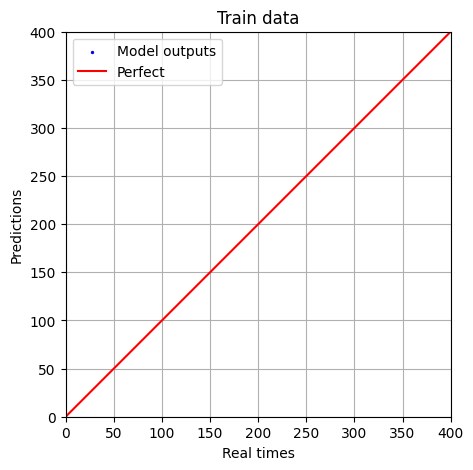

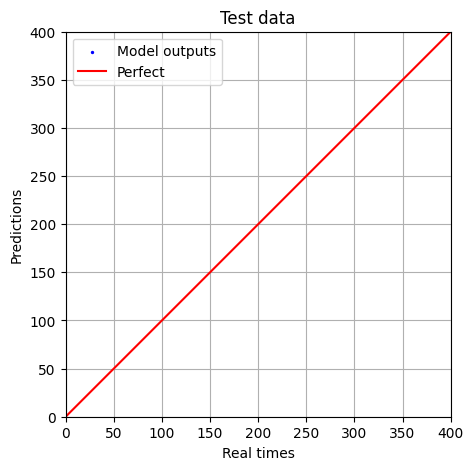

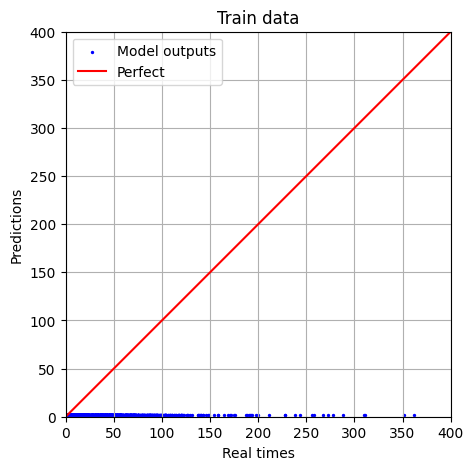

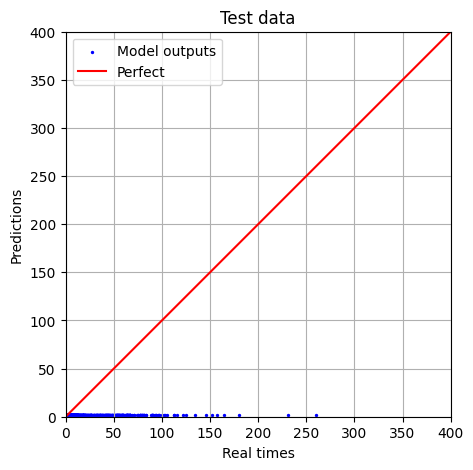

Epochs:   0%|          | 1/1000 [00:03<54:36,  3.28s/it]


New best: 002, Train Loss: 634.537109
Test MSE = 720.06884765625
Test L1 = 9.027812004089355
Test R2 = -0.07727301120758057
Test MAPE = 6.696046829223633
Test Spearman = 0.5586045384407043


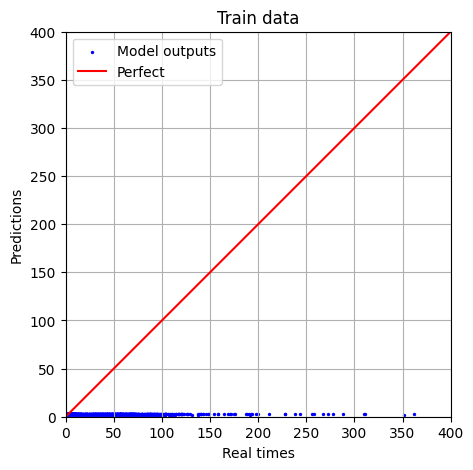

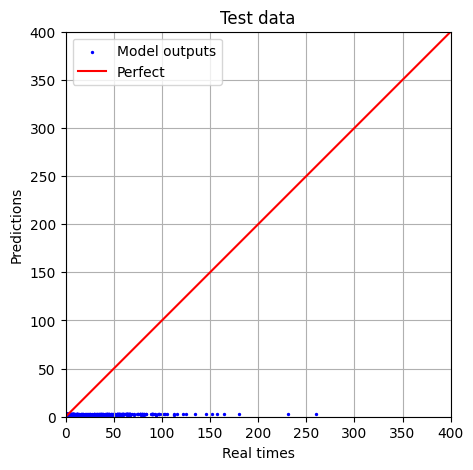

Epochs:   0%|          | 2/1000 [00:06<51:13,  3.08s/it]

Epochs:   0%|          | 5/1000 [00:13<40:56,  2.47s/it]

New best: 006, Train Loss: 613.604492
Test MSE = 698.6243286132812
Test L1 = 8.838545799255371
Test R2 = -0.04519057273864746
Test MAPE = 6.106330394744873
Test Spearman = 0.5588437914848328


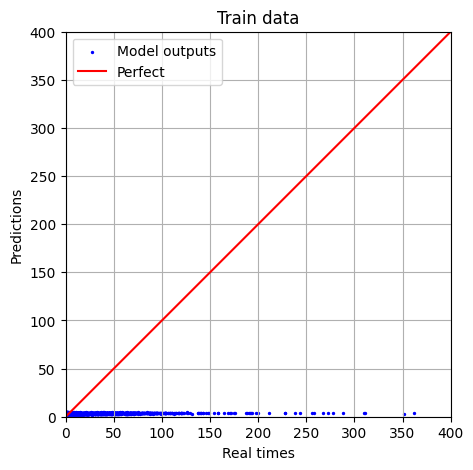

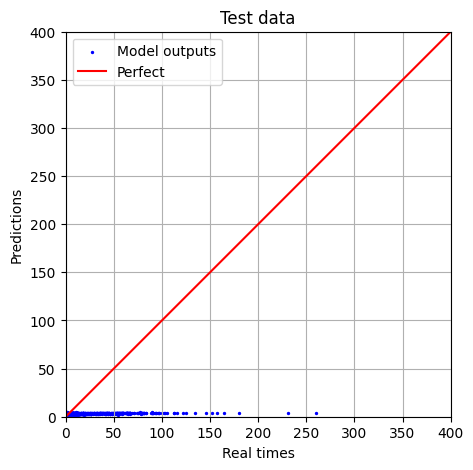

Epochs:   1%|          | 6/1000 [00:16<43:47,  2.64s/it]

Epochs:   1%|          | 8/1000 [00:20<41:26,  2.51s/it]

New best: 009, Train Loss: 572.039001
Test MSE = 655.9824829101562
Test L1 = 8.945971488952637
Test R2 = 0.018604576587677002
Test MAPE = 11.63093376159668
Test Spearman = 0.5592817068099976


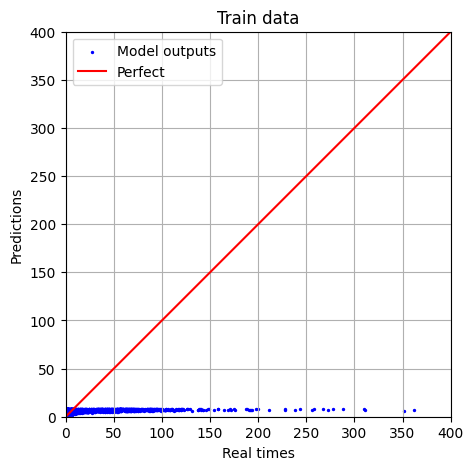

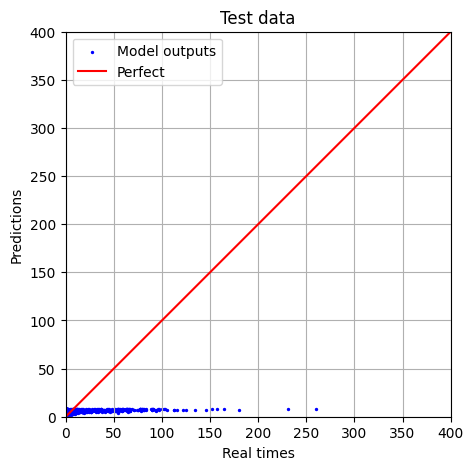

Epochs:   1%|          | 9/1000 [00:24<44:40,  2.71s/it]

Epochs:   1%|          | 10/1000 [00:26<43:45,  2.65s/it]

Train Loss: 606.851135
Test MSE = 691.7472534179688
Test L1 = 8.794143676757812
Test R2 = -0.034901976585388184
Test MAPE = 4.2364277839660645
Test Spearman = 0.5602875351905823
--------------------------------------------------------------------------------


Epochs:   1%|          | 11/1000 [00:28<42:22,  2.57s/it]

New best: 012, Train Loss: 531.895325
Test MSE = 614.6948852539062
Test L1 = 10.007857322692871
Test R2 = 0.08037376403808594
Test MAPE = 21.595081329345703
Test Spearman = 0.5577641725540161


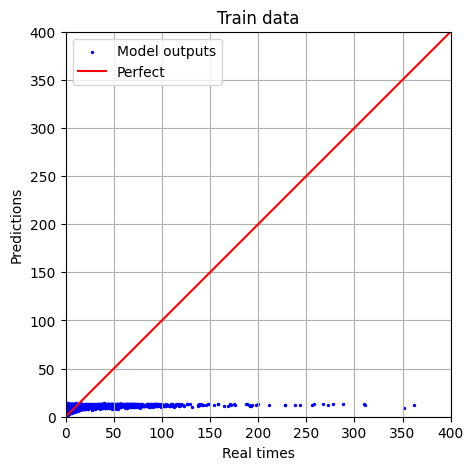

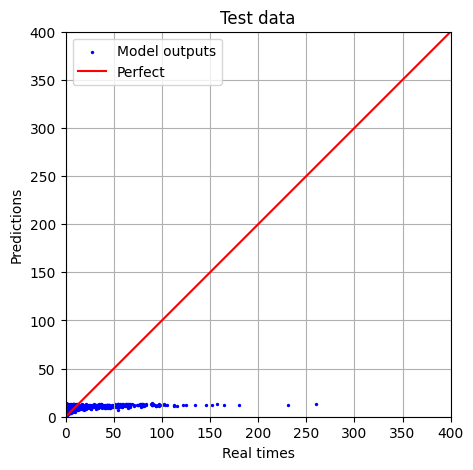

Epochs:   1%|          | 12/1000 [00:31<43:06,  2.62s/it]

Epochs:   2%|▏         | 15/1000 [00:38<38:01,  2.32s/it]

New best: 016, Train Loss: 517.847534
Test MSE = 600.4353637695312
Test L1 = 10.028983116149902
Test R2 = 0.10170698165893555
Test MAPE = 20.08080291748047
Test Spearman = 0.5569639801979065


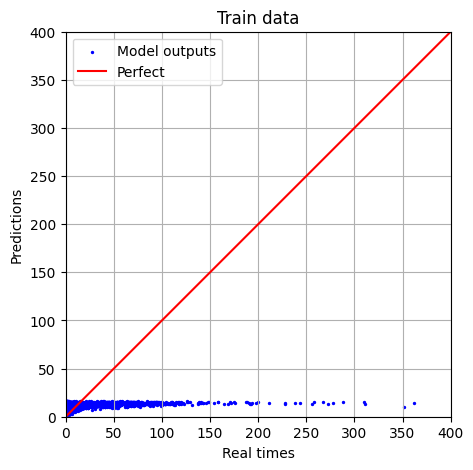

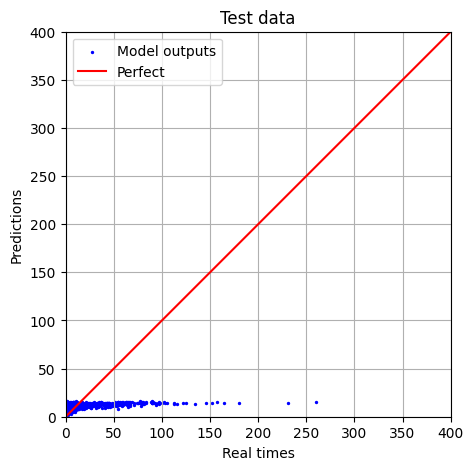

Epochs:   2%|▏         | 16/1000 [00:40<39:59,  2.44s/it]

Epochs:   2%|▏         | 20/1000 [00:49<37:44,  2.31s/it]

Train Loss: 549.004333
Test MSE = 632.5620727539062
Test L1 = 8.620301246643066
Test R2 = 0.05364316701889038
Test MAPE = 7.091915130615234
Test Spearman = 0.5072581171989441
--------------------------------------------------------------------------------


Epochs:   2%|▏         | 21/1000 [00:52<37:09,  2.28s/it]

New best: 022, Train Loss: 516.488831
Test MSE = 599.3086547851562
Test L1 = 9.132895469665527
Test R2 = 0.1033926010131836
Test MAPE = 13.039867401123047
Test Spearman = 0.5550745129585266


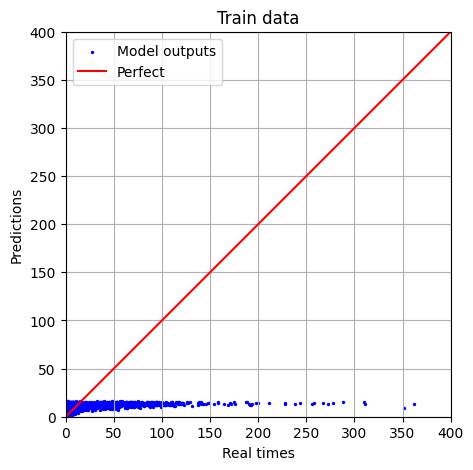

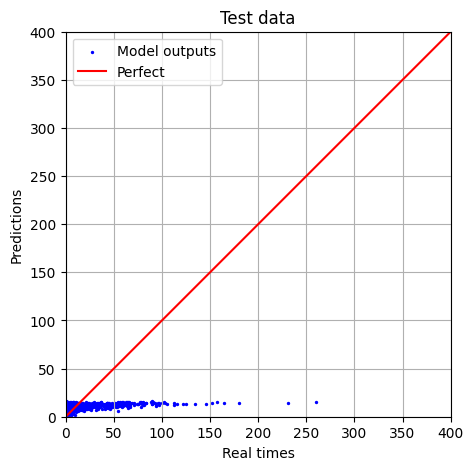

Epochs:   2%|▏         | 22/1000 [00:54<39:19,  2.41s/it]


New best: 023, Train Loss: 505.434204
Test MSE = 587.8433837890625
Test L1 = 10.305514335632324
Test R2 = 0.1205453872680664
Test MAPE = 20.749074935913086
Test Spearman = 0.556769609451294


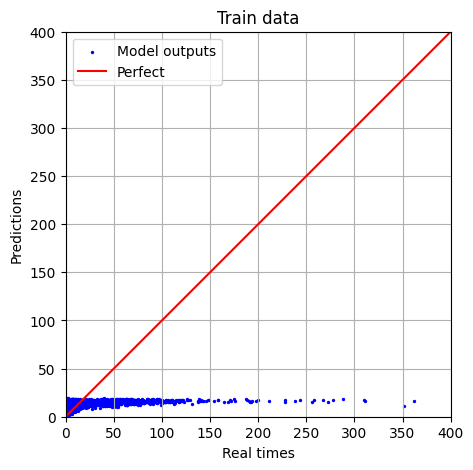

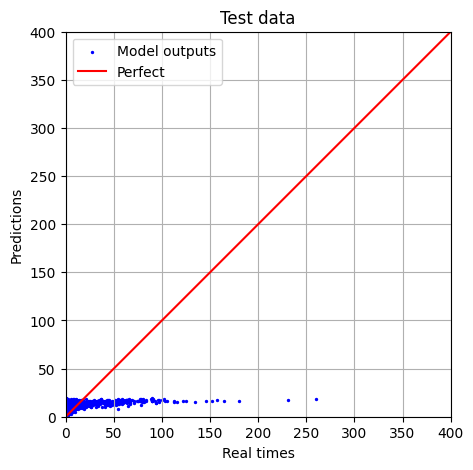

Epochs:   2%|▏         | 23/1000 [00:57<41:01,  2.52s/it]

Epochs:   3%|▎         | 30/1000 [01:12<35:22,  2.19s/it]

Train Loss: 571.845032
Test MSE = 655.9138793945312
Test L1 = 8.688511848449707
Test R2 = 0.018707275390625
Test MAPE = 6.990174770355225
Test Spearman = 0.5628196001052856
--------------------------------------------------------------------------------


Epochs:   4%|▍         | 40/1000 [01:33<34:32,  2.16s/it]

Train Loss: 639.402283
Test MSE = 724.88134765625
Test L1 = 9.035014152526855
Test R2 = -0.0844728946685791
Test MAPE = 4.7560319900512695
Test Spearman = 0.5804914236068726
--------------------------------------------------------------------------------


Epochs:   5%|▌         | 50/1000 [01:55<35:32,  2.24s/it]

Train Loss: 617.232178
Test MSE = 697.1009521484375
Test L1 = 19.00200080871582
Test R2 = -0.042911410331726074
Test MAPE = 77.52584075927734
Test Spearman = 0.6088601350784302
--------------------------------------------------------------------------------


Epochs:   6%|▌         | 60/1000 [02:16<34:32,  2.21s/it]

Train Loss: 663.651245
Test MSE = 749.964599609375
Test L1 = 9.233572959899902
Test R2 = -0.12199914455413818
Test MAPE = 2.495372772216797
Test Spearman = 0.1893264204263687
--------------------------------------------------------------------------------


Epochs:   6%|▋         | 65/1000 [02:27<33:17,  2.14s/it]

New best: 066, Train Loss: 491.831451
Test MSE = 573.2069091796875
Test L1 = 11.389750480651855
Test R2 = 0.14244258403778076
Test MAPE = 26.834228515625
Test Spearman = 0.5978367328643799


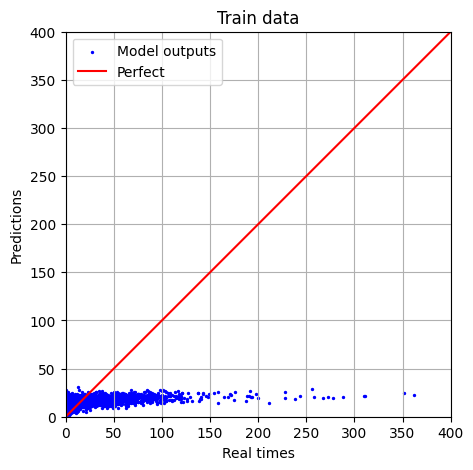

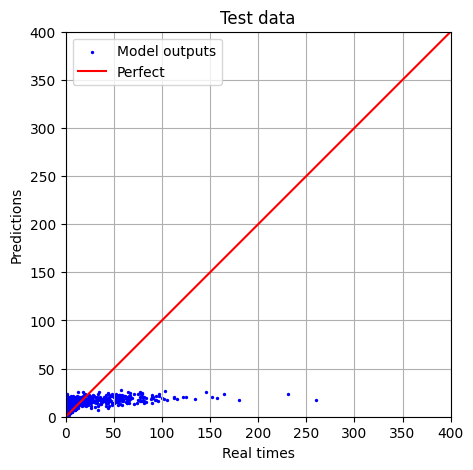

Epochs:   7%|▋         | 66/1000 [02:30<35:59,  2.31s/it]

Epochs:   7%|▋         | 70/1000 [02:38<34:40,  2.24s/it]

Train Loss: 568.802063
Test MSE = 652.702392578125
Test L1 = 8.514117240905762
Test R2 = 0.023511886596679688
Test MAPE = 4.44129753112793
Test Spearman = 0.5907432436943054
--------------------------------------------------------------------------------


Epochs:   8%|▊         | 80/1000 [03:00<34:05,  2.22s/it]

Train Loss: 641.475403
Test MSE = 728.05224609375
Test L1 = 9.090145111083984
Test R2 = -0.08921682834625244
Test MAPE = 2.221330404281616
Test Spearman = 0.40402573347091675
--------------------------------------------------------------------------------


Epochs:   9%|▉         | 90/1000 [03:22<33:37,  2.22s/it]

Train Loss: 742.217896
Test MSE = 822.3033447265625
Test L1 = 22.659378051757812
Test R2 = -0.2302229404449463
Test MAPE = 95.39350128173828
Test Spearman = 0.6097557544708252
--------------------------------------------------------------------------------


Epochs:  10%|█         | 100/1000 [03:43<33:23,  2.23s/it]

Train Loss: 505.375580
Test MSE = 588.0203247070312
Test L1 = 8.910255432128906
Test R2 = 0.12028074264526367
Test MAPE = 10.570212364196777
Test Spearman = 0.5925918221473694
--------------------------------------------------------------------------------


Epochs:  11%|█         | 110/1000 [04:05<33:01,  2.23s/it]

Train Loss: 1508.771118
Test MSE = 1591.193359375
Test L1 = 35.94464874267578
Test R2 = -1.3805358409881592
Test MAPE = 168.96029663085938
Test Spearman = 0.6108026504516602
--------------------------------------------------------------------------------


Epochs:  12%|█▏        | 120/1000 [04:27<32:17,  2.20s/it]

Train Loss: 669.978699
Test MSE = 756.4303588867188
Test L1 = 9.402414321899414
Test R2 = -0.13167238235473633
Test MAPE = 1.2943074703216553
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  12%|█▏        | 123/1000 [04:33<31:29,  2.15s/it]

New best: 124, Train Loss: 488.202850
Test MSE = 569.9164428710938
Test L1 = 11.93291187286377
Test R2 = 0.14736539125442505
Test MAPE = 28.650827407836914
Test Spearman = 0.601909875869751


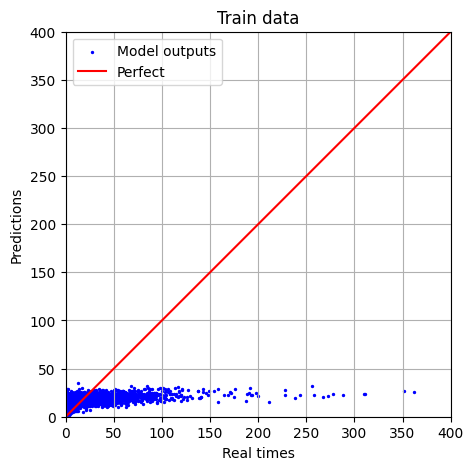

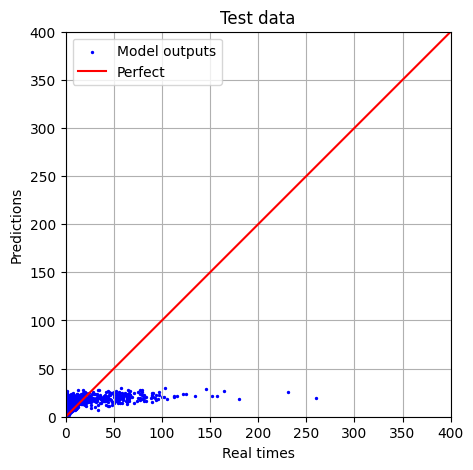

Epochs:  12%|█▏        | 124/1000 [04:36<33:53,  2.32s/it]

Epochs:  13%|█▎        | 130/1000 [04:49<32:17,  2.23s/it]

Train Loss: 663.658203
Test MSE = 749.9970703125
Test L1 = 9.398750305175781
Test R2 = -0.1220477819442749
Test MAPE = 1.118973970413208
Test Spearman = 0.36172643303871155
--------------------------------------------------------------------------------


Epochs:  14%|█▍        | 140/1000 [05:10<31:24,  2.19s/it]

Train Loss: 651.839355
Test MSE = 739.230224609375
Test L1 = 9.351046562194824
Test R2 = -0.10593974590301514
Test MAPE = 1.0324448347091675
Test Spearman = 0.40936294198036194
--------------------------------------------------------------------------------


Epochs:  15%|█▌        | 150/1000 [05:32<31:02,  2.19s/it]

Train Loss: 673.687317
Test MSE = 760.2299194335938
Test L1 = 9.581842422485352
Test R2 = -0.13735687732696533
Test MAPE = 1.117556095123291
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  16%|█▌        | 160/1000 [05:53<31:05,  2.22s/it]

Train Loss: 4089.768799
Test MSE = 4188.66796875
Test L1 = 61.949893951416016
Test R2 = -5.266538619995117
Test MAPE = 299.5279846191406
Test Spearman = 0.576585054397583
--------------------------------------------------------------------------------


Epochs:  17%|█▋        | 170/1000 [06:15<30:39,  2.22s/it]

Train Loss: 494.803467
Test MSE = 577.0972900390625
Test L1 = 9.339143753051758
Test R2 = 0.13662230968475342
Test MAPE = 13.308422088623047
Test Spearman = 0.5760825872421265
--------------------------------------------------------------------------------


Epochs:  18%|█▊        | 180/1000 [06:37<30:29,  2.23s/it]

Train Loss: 628.693787
Test MSE = 713.81494140625
Test L1 = 9.336033821105957
Test R2 = -0.06791675090789795
Test MAPE = 2.517103910446167
Test Spearman = 0.534734845161438
--------------------------------------------------------------------------------


Epochs:  19%|█▉        | 190/1000 [06:58<29:38,  2.20s/it]

Train Loss: 578.873596
Test MSE = 662.90185546875
Test L1 = 8.966480255126953
Test R2 = 0.008252739906311035
Test MAPE = 3.8932769298553467
Test Spearman = 0.5619058609008789
--------------------------------------------------------------------------------


Epochs:  20%|██        | 200/1000 [07:20<29:13,  2.19s/it]

Train Loss: 635.556396
Test MSE = 720.7687377929688
Test L1 = 9.48528003692627
Test R2 = -0.07832014560699463
Test MAPE = 3.1558218002319336
Test Spearman = 0.543379545211792
--------------------------------------------------------------------------------


Epochs:  21%|██        | 210/1000 [07:41<29:08,  2.21s/it]

Train Loss: 635.623474
Test MSE = 720.8046875
Test L1 = 9.528116226196289
Test R2 = -0.07837390899658203
Test MAPE = 3.5013813972473145
Test Spearman = 0.5498783588409424
--------------------------------------------------------------------------------


Epochs:  22%|██▏       | 220/1000 [08:03<28:32,  2.20s/it]

Train Loss: 655.197937
Test MSE = 740.8745727539062
Test L1 = 9.787155151367188
Test R2 = -0.10839986801147461
Test MAPE = 3.786924362182617
Test Spearman = 0.49664294719696045
--------------------------------------------------------------------------------


Epochs:  23%|██▎       | 230/1000 [08:24<28:05,  2.19s/it]

Train Loss: 661.795837
Test MSE = 747.678955078125
Test L1 = 9.895030975341797
Test R2 = -0.11857974529266357
Test MAPE = 4.1199541091918945
Test Spearman = 0.5055116415023804
--------------------------------------------------------------------------------


Epochs:  24%|██▍       | 240/1000 [08:46<27:45,  2.19s/it]

Train Loss: 662.826904
Test MSE = 748.7652587890625
Test L1 = 9.914655685424805
Test R2 = -0.12020492553710938
Test MAPE = 4.416579246520996
Test Spearman = 0.5329282879829407
--------------------------------------------------------------------------------


Epochs:  25%|██▌       | 250/1000 [09:07<27:25,  2.19s/it]

Train Loss: 667.293823
Test MSE = 753.437255859375
Test L1 = 10.00063705444336
Test R2 = -0.12719452381134033
Test MAPE = 4.750402450561523
Test Spearman = 0.5491686463356018
--------------------------------------------------------------------------------


Epochs:  26%|██▌       | 260/1000 [09:29<27:10,  2.20s/it]

Train Loss: 674.313721
Test MSE = 760.693603515625
Test L1 = 10.161856651306152
Test R2 = -0.13805043697357178
Test MAPE = 5.182687759399414
Test Spearman = 0.5253695845603943
--------------------------------------------------------------------------------


Epochs:  27%|██▋       | 270/1000 [09:50<26:50,  2.21s/it]

Train Loss: 670.461609
Test MSE = 756.7373657226562
Test L1 = 10.110383033752441
Test R2 = -0.1321316957473755
Test MAPE = 5.404867172241211
Test Spearman = 0.5499159097671509
--------------------------------------------------------------------------------


Epochs:  28%|██▊       | 280/1000 [10:12<26:21,  2.20s/it]

Train Loss: 680.767334
Test MSE = 767.320556640625
Test L1 = 10.351819038391113
Test R2 = -0.14796483516693115
Test MAPE = 5.9031805992126465
Test Spearman = 0.49509307742118835
--------------------------------------------------------------------------------


Epochs:  29%|██▉       | 290/1000 [10:33<25:59,  2.20s/it]

Train Loss: 676.212036
Test MSE = 762.6560668945312
Test L1 = 10.296330451965332
Test R2 = -0.14098656177520752
Test MAPE = 6.1274518966674805
Test Spearman = 0.5283463597297668
--------------------------------------------------------------------------------


Epochs:  30%|███       | 300/1000 [10:55<26:09,  2.24s/it]

Train Loss: 684.314270
Test MSE = 770.9911499023438
Test L1 = 10.487417221069336
Test R2 = -0.15345633029937744
Test MAPE = 6.550262451171875
Test Spearman = 0.49731022119522095
--------------------------------------------------------------------------------


Epochs:  31%|███       | 310/1000 [11:17<25:43,  2.24s/it]

Train Loss: 679.977112
Test MSE = 766.553955078125
Test L1 = 10.43748664855957
Test R2 = -0.14681804180145264
Test MAPE = 6.740810394287109
Test Spearman = 0.5156006813049316
--------------------------------------------------------------------------------


Epochs:  32%|███▏      | 320/1000 [11:39<25:20,  2.24s/it]

Train Loss: 682.588501
Test MSE = 769.2176513671875
Test L1 = 10.526205062866211
Test R2 = -0.1508030891418457
Test MAPE = 7.052984237670898
Test Spearman = 0.49663370847702026
--------------------------------------------------------------------------------


Epochs:  33%|███▎      | 330/1000 [12:00<25:16,  2.26s/it]

Train Loss: 685.496277
Test MSE = 772.1492309570312
Test L1 = 10.620869636535645
Test R2 = -0.1551889181137085
Test MAPE = 7.360950946807861
Test Spearman = 0.47120028734207153
--------------------------------------------------------------------------------


Epochs:  34%|███▍      | 340/1000 [12:22<24:18,  2.21s/it]

Train Loss: 688.181396
Test MSE = 774.9307250976562
Test L1 = 10.690322875976562
Test R2 = -0.15935015678405762
Test MAPE = 7.623319625854492
Test Spearman = 0.4885404109954834
--------------------------------------------------------------------------------


Epochs:  35%|███▌      | 350/1000 [12:43<23:44,  2.19s/it]

Train Loss: 687.233887
Test MSE = 773.8963012695312
Test L1 = 10.712663650512695
Test R2 = -0.15780270099639893
Test MAPE = 7.818845272064209
Test Spearman = 0.4551405906677246
--------------------------------------------------------------------------------


Epochs:  36%|███▌      | 360/1000 [13:05<23:28,  2.20s/it]

Train Loss: 685.585205
Test MSE = 772.236083984375
Test L1 = 10.691797256469727
Test R2 = -0.15531885623931885
Test MAPE = 7.934009075164795
Test Spearman = 0.49730321764945984
--------------------------------------------------------------------------------


Epochs:  37%|███▋      | 370/1000 [13:27<23:22,  2.23s/it]

Train Loss: 692.561218
Test MSE = 779.402587890625
Test L1 = 10.841231346130371
Test R2 = -0.16604042053222656
Test MAPE = 8.232600212097168
Test Spearman = 0.45012688636779785
--------------------------------------------------------------------------------


Epochs:  38%|███▊      | 380/1000 [13:48<22:53,  2.21s/it]

Train Loss: 690.624268
Test MSE = 777.3903198242188
Test L1 = 10.83156967163086
Test R2 = -0.16302990913391113
Test MAPE = 8.377103805541992
Test Spearman = 0.4687098562717438
--------------------------------------------------------------------------------


Epochs:  39%|███▉      | 390/1000 [14:10<22:30,  2.21s/it]

Train Loss: 692.927307
Test MSE = 779.757080078125
Test L1 = 10.892552375793457
Test R2 = -0.166570782661438
Test MAPE = 8.565945625305176
Test Spearman = 0.45468083024024963
--------------------------------------------------------------------------------


Epochs:  40%|████      | 400/1000 [14:31<21:58,  2.20s/it]

Train Loss: 691.369446
Test MSE = 778.1798095703125
Test L1 = 10.875319480895996
Test R2 = -0.16421103477478027
Test MAPE = 8.668554306030273
Test Spearman = 0.4887257516384125
--------------------------------------------------------------------------------


Epochs:  41%|████      | 410/1000 [14:53<21:31,  2.19s/it]

Train Loss: 690.687195
Test MSE = 777.4210205078125
Test L1 = 10.891289710998535
Test R2 = -0.16307580471038818
Test MAPE = 8.794720649719238
Test Spearman = 0.4563080370426178
--------------------------------------------------------------------------------


Epochs:  42%|████▏     | 420/1000 [15:15<21:22,  2.21s/it]

Train Loss: 694.873413
Test MSE = 781.7449951171875
Test L1 = 10.969951629638672
Test R2 = -0.16954481601715088
Test MAPE = 8.946510314941406
Test Spearman = 0.45558077096939087
--------------------------------------------------------------------------------


Epochs:  43%|████▎     | 430/1000 [15:36<21:03,  2.22s/it]

Train Loss: 700.169983
Test MSE = 787.2062377929688
Test L1 = 11.079705238342285
Test R2 = -0.17771518230438232
Test MAPE = 9.179510116577148
Test Spearman = 0.40074172616004944
--------------------------------------------------------------------------------


Epochs:  44%|████▍     | 440/1000 [15:58<20:42,  2.22s/it]

Train Loss: 699.416443
Test MSE = 786.4258422851562
Test L1 = 11.078046798706055
Test R2 = -0.17654776573181152
Test MAPE = 9.248196601867676
Test Spearman = 0.41432419419288635
--------------------------------------------------------------------------------


Epochs:  45%|████▌     | 450/1000 [16:19<20:13,  2.21s/it]

Train Loss: 701.535278
Test MSE = 788.5905151367188
Test L1 = 11.12375545501709
Test R2 = -0.17978620529174805
Test MAPE = 9.369296073913574
Test Spearman = 0.38669881224632263
--------------------------------------------------------------------------------


Epochs:  46%|████▌     | 460/1000 [16:41<19:58,  2.22s/it]

Train Loss: 701.366577
Test MSE = 788.4342651367188
Test L1 = 11.125868797302246
Test R2 = -0.17955243587493896
Test MAPE = 9.424399375915527
Test Spearman = 0.4175228774547577
--------------------------------------------------------------------------------


Epochs:  47%|████▋     | 470/1000 [17:03<19:39,  2.23s/it]

Train Loss: 702.612854
Test MSE = 789.714599609375
Test L1 = 11.159884452819824
Test R2 = -0.18146789073944092
Test MAPE = 9.538741111755371
Test Spearman = 0.39184412360191345
--------------------------------------------------------------------------------


Epochs:  48%|████▊     | 480/1000 [17:25<19:22,  2.24s/it]

Train Loss: 701.655029
Test MSE = 788.7128295898438
Test L1 = 11.153218269348145
Test R2 = -0.1799691915512085
Test MAPE = 9.586977005004883
Test Spearman = 0.41473808884620667
--------------------------------------------------------------------------------


Epochs:  49%|████▉     | 490/1000 [17:46<19:01,  2.24s/it]

Train Loss: 702.313049
Test MSE = 789.3870239257812
Test L1 = 11.174510955810547
Test R2 = -0.18097782135009766
Test MAPE = 9.675924301147461
Test Spearman = 0.4102041721343994
--------------------------------------------------------------------------------


Epochs:  50%|████▉     | 499/1000 [18:06<17:54,  2.15s/it]

New best: 500, Train Loss: 482.616608
Test MSE = 562.7525024414062
Test L1 = 12.036127090454102
Test R2 = 0.15808314085006714
Test MAPE = 34.470829010009766
Test Spearman = 0.5807583332061768


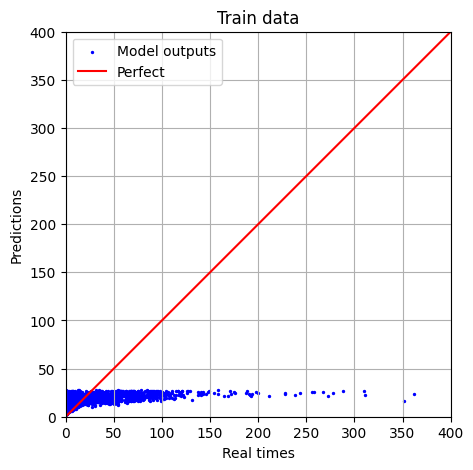

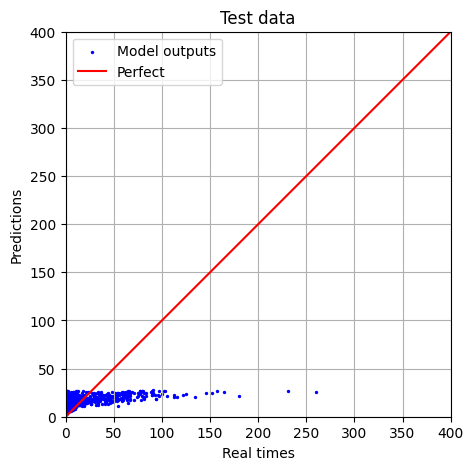

Epochs:  50%|█████     | 500/1000 [18:09<19:58,  2.40s/it]

Train Loss: 482.616608
Test MSE = 562.7523803710938
Test L1 = 12.036127090454102
Test R2 = 0.15808331966400146
Test MAPE = 34.470829010009766
Test Spearman = 0.5807583332061768
--------------------------------------------------------------------------------


Epochs:  51%|█████     | 506/1000 [18:22<17:58,  2.18s/it]

New best: 507, Train Loss: 482.378693
Test MSE = 561.0026245117188
Test L1 = 14.342291831970215
Test R2 = 0.16070103645324707
Test MAPE = 46.02703857421875
Test Spearman = 0.612106442451477


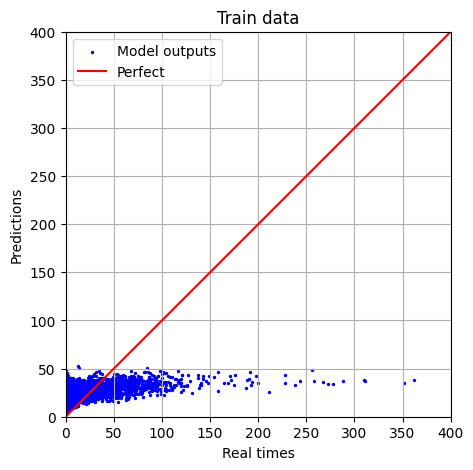

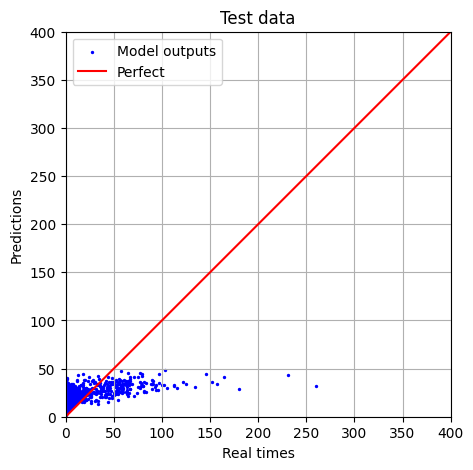

Epochs:  51%|█████     | 507/1000 [18:24<19:14,  2.34s/it]

Epochs:  51%|█████     | 508/1000 [18:27<18:43,  2.28s/it]

New best: 509, Train Loss: 481.131744
Test MSE = 561.6478271484375
Test L1 = 9.865399360656738
Test R2 = 0.15973585844039917
Test MAPE = 19.925188064575195
Test Spearman = 0.613825261592865


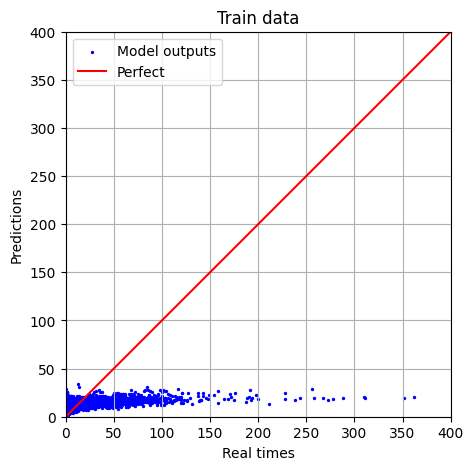

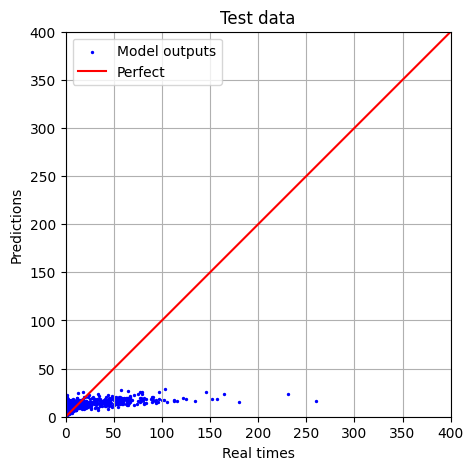

Epochs:  51%|█████     | 509/1000 [18:29<19:42,  2.41s/it]

Epochs:  51%|█████     | 510/1000 [18:32<19:43,  2.41s/it]

Train Loss: 708.233215
Test MSE = 795.5440063476562
Test L1 = 11.275015830993652
Test R2 = -0.19018912315368652
Test MAPE = 9.878294944763184
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  51%|█████     | 511/1000 [18:34<19:04,  2.34s/it]

New best: 512, Train Loss: 475.192108
Test MSE = 556.6266479492188
Test L1 = 10.041102409362793
Test R2 = 0.16724789142608643
Test MAPE = 21.0633602142334
Test Spearman = 0.6141270399093628


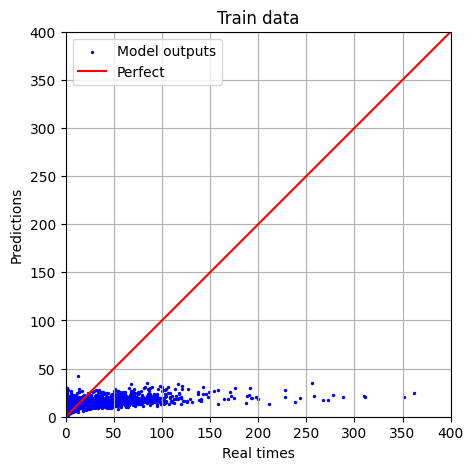

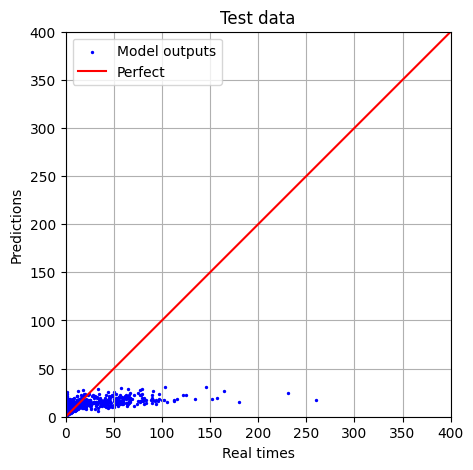

Epochs:  51%|█████     | 512/1000 [18:37<20:00,  2.46s/it]

Epochs:  52%|█████▏    | 520/1000 [18:54<18:06,  2.26s/it]

Train Loss: 708.734070
Test MSE = 796.05517578125
Test L1 = 11.297656059265137
Test R2 = -0.19095385074615479
Test MAPE = 9.995443344116211
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  53%|█████▎    | 530/1000 [19:16<17:30,  2.23s/it]

Train Loss: 3165.070068
Test MSE = 3308.71044921875
Test L1 = 51.310394287109375
Test R2 = -3.9500608444213867
Test MAPE = 166.50057983398438
Test Spearman = 0.6204239130020142
--------------------------------------------------------------------------------


Epochs:  54%|█████▍    | 540/1000 [19:38<17:04,  2.23s/it]

Train Loss: 561.514160
Test MSE = 645.9171752929688
Test L1 = 8.691344261169434
Test R2 = 0.03366297483444214
Test MAPE = 7.760460376739502
Test Spearman = 0.615121066570282
--------------------------------------------------------------------------------


Epochs:  55%|█████▌    | 550/1000 [20:00<16:48,  2.24s/it]

Train Loss: 791.066589
Test MSE = 880.4938354492188
Test L1 = 22.566226959228516
Test R2 = -0.3172799348831177
Test MAPE = 74.14636993408203
Test Spearman = 0.6175834536552429
--------------------------------------------------------------------------------


Epochs:  56%|█████▌    | 560/1000 [20:21<16:10,  2.21s/it]

Train Loss: 710.084045
Test MSE = 797.4448852539062
Test L1 = 11.359915733337402
Test R2 = -0.19303297996520996
Test MAPE = 10.318319320678711
Test Spearman = 0.1225597932934761
--------------------------------------------------------------------------------


Epochs:  57%|█████▋    | 570/1000 [20:43<15:56,  2.23s/it]

Train Loss: 710.378418
Test MSE = 797.733154296875
Test L1 = 11.371673583984375
Test R2 = -0.19346415996551514
Test MAPE = 10.378421783447266
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  58%|█████▊    | 580/1000 [21:05<15:29,  2.21s/it]

Train Loss: 689.049561
Test MSE = 776.0896606445312
Test L1 = 11.072346687316895
Test R2 = -0.16108405590057373
Test MAPE = 10.19647216796875
Test Spearman = 0.5243254899978638
--------------------------------------------------------------------------------


Epochs:  59%|█████▉    | 588/1000 [21:22<14:43,  2.14s/it]

New best: 589, Train Loss: 439.495850
Test MSE = 519.1992797851562
Test L1 = 11.299242973327637
Test R2 = 0.22324180603027344
Test MAPE = 26.92209815979004
Test Spearman = 0.6176176071166992


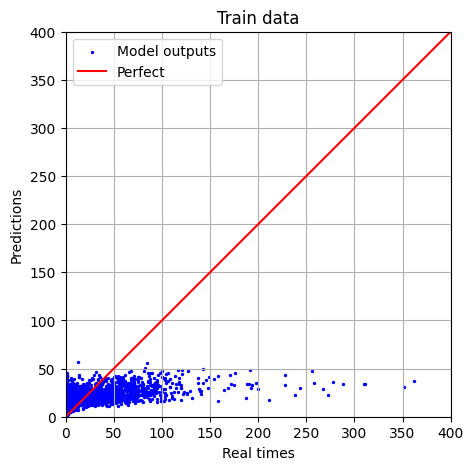

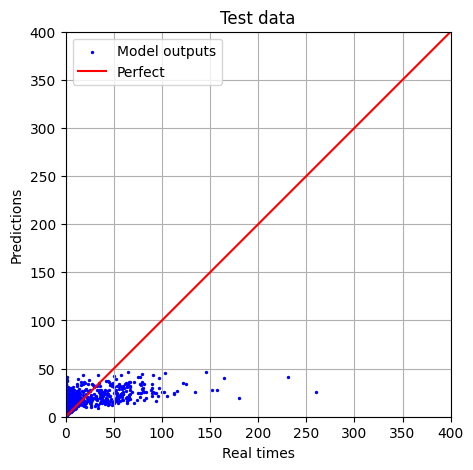

Epochs:  59%|█████▉    | 589/1000 [21:25<16:08,  2.36s/it]

Epochs:  59%|█████▉    | 590/1000 [21:27<16:10,  2.37s/it]

Train Loss: 711.283081
Test MSE = 798.6561889648438
Test L1 = 11.412188529968262
Test R2 = -0.19484519958496094
Test MAPE = 10.58804988861084
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  60%|██████    | 600/1000 [21:48<14:39,  2.20s/it]

Train Loss: 687.944641
Test MSE = 774.8823852539062
Test L1 = 11.02691650390625
Test R2 = -0.15927791595458984
Test MAPE = 10.318563461303711
Test Spearman = 0.5725560784339905
--------------------------------------------------------------------------------


Epochs:  61%|██████    | 610/1000 [22:10<14:14,  2.19s/it]

Train Loss: 652.006897
Test MSE = 738.1412963867188
Test L1 = 10.276323318481445
Test R2 = -0.10431063175201416
Test MAPE = 9.606826782226562
Test Spearman = 0.611097514629364
--------------------------------------------------------------------------------


Epochs:  62%|██████▏   | 620/1000 [22:31<13:57,  2.20s/it]

Train Loss: 464.346039
Test MSE = 545.4076538085938
Test L1 = 13.356663703918457
Test R2 = 0.18403226137161255
Test MAPE = 34.554439544677734
Test Spearman = 0.6097832322120667
--------------------------------------------------------------------------------


Epochs:  63%|██████▎   | 630/1000 [22:53<13:38,  2.21s/it]

Train Loss: 534.342896
Test MSE = 617.5599365234375
Test L1 = 8.479351997375488
Test R2 = 0.07608741521835327
Test MAPE = 7.826397895812988
Test Spearman = 0.6163420081138611
--------------------------------------------------------------------------------


Epochs:  64%|██████▍   | 640/1000 [23:14<13:12,  2.20s/it]

Train Loss: 4363.319336
Test MSE = 4518.1640625
Test L1 = 60.09149169921875
Test R2 = -5.759487628936768
Test MAPE = 187.524169921875
Test Spearman = 0.6154284477233887
--------------------------------------------------------------------------------


Epochs:  65%|██████▌   | 650/1000 [23:36<12:59,  2.23s/it]

Train Loss: 713.655090
Test MSE = 801.0759887695312
Test L1 = 11.517721176147461
Test R2 = -0.19846534729003906
Test MAPE = 11.134096145629883
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  66%|██████▌   | 660/1000 [23:58<12:41,  2.24s/it]

Train Loss: 685.802246
Test MSE = 772.728515625
Test L1 = 11.03967571258545
Test R2 = -0.15605556964874268
Test MAPE = 10.731508255004883
Test Spearman = 0.5848037600517273
--------------------------------------------------------------------------------


Epochs:  67%|██████▋   | 670/1000 [24:20<12:07,  2.21s/it]

Train Loss: 714.012451
Test MSE = 801.4439697265625
Test L1 = 11.53390884399414
Test R2 = -0.19901585578918457
Test MAPE = 11.218005180358887
Test Spearman = 0.052250951528549194
--------------------------------------------------------------------------------


Epochs:  68%|██████▊   | 680/1000 [24:41<11:49,  2.22s/it]

Train Loss: 714.422607
Test MSE = 801.8590087890625
Test L1 = 11.55165958404541
Test R2 = -0.1996368169784546
Test MAPE = 11.309693336486816
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  69%|██████▉   | 690/1000 [25:03<11:26,  2.21s/it]

Train Loss: 687.997986
Test MSE = 775.037109375
Test L1 = 11.111621856689453
Test R2 = -0.1595093011856079
Test MAPE = 10.974711418151855
Test Spearman = 0.5748563408851624
--------------------------------------------------------------------------------


Epochs:  70%|███████   | 700/1000 [25:25<11:06,  2.22s/it]

Train Loss: 714.904724
Test MSE = 802.3505859375
Test L1 = 11.572920799255371
Test R2 = -0.20037221908569336
Test MAPE = 11.419706344604492
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  71%|███████   | 710/1000 [25:46<10:37,  2.20s/it]

Train Loss: 517.756287
Test MSE = 601.4482421875
Test L1 = 8.472970962524414
Test R2 = 0.10019159317016602
Test MAPE = 8.478565216064453
Test Spearman = 0.6148788928985596
--------------------------------------------------------------------------------
New best: 711, Train Loss: 439.178711
Test MSE = 517.98828125
Test L1 = 10.823014259338379
Test R2 = 0.22505348920822144
Test MAPE = 24.005619049072266
Test Spearman = 0.6164427399635315


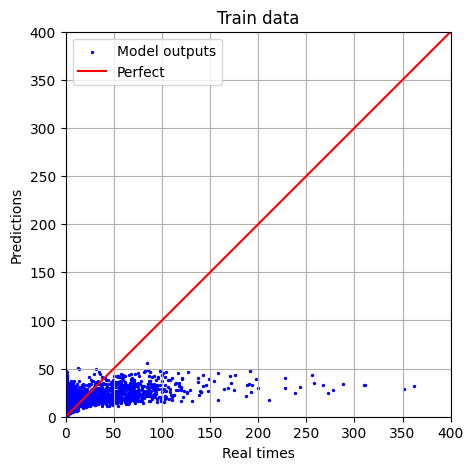

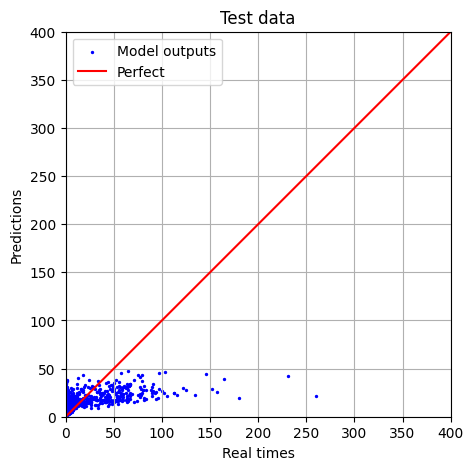

Epochs:  71%|███████   | 711/1000 [25:49<11:20,  2.35s/it]

Epochs:  72%|███████▏  | 720/1000 [26:08<10:18,  2.21s/it]

Train Loss: 715.481262
Test MSE = 802.938720703125
Test L1 = 11.598301887512207
Test R2 = -0.20125210285186768
Test MAPE = 11.55102825164795
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  73%|███████▎  | 730/1000 [26:30<09:53,  2.20s/it]

Train Loss: 693.649353
Test MSE = 780.7654418945312
Test L1 = 11.264044761657715
Test R2 = -0.16807937622070312
Test MAPE = 11.360383033752441
Test Spearman = 0.5643405914306641
--------------------------------------------------------------------------------


Epochs:  74%|███████▍  | 740/1000 [26:52<09:31,  2.20s/it]

Train Loss: 716.163574
Test MSE = 803.6669311523438
Test L1 = 11.631431579589844
Test R2 = -0.20234155654907227
Test MAPE = 11.723991394042969
Test Spearman = 0.11527424305677414
--------------------------------------------------------------------------------


Epochs:  75%|███████▌  | 750/1000 [27:13<09:12,  2.21s/it]

Train Loss: 676.518250
Test MSE = 763.0393676757812
Test L1 = 10.847672462463379
Test R2 = -0.14155995845794678
Test MAPE = 10.975043296813965
Test Spearman = 0.6052404046058655
--------------------------------------------------------------------------------


Epochs:  76%|███████▌  | 760/1000 [27:35<08:46,  2.19s/it]

Train Loss: 639.694031
Test MSE = 725.6669921875
Test L1 = 9.964977264404297
Test R2 = -0.0856482982635498
Test MAPE = 9.513619422912598
Test Spearman = 0.6189866662025452
--------------------------------------------------------------------------------


Epochs:  77%|███████▋  | 770/1000 [27:56<08:25,  2.20s/it]

Train Loss: 716.945374
Test MSE = 804.4320678710938
Test L1 = 11.66249942779541
Test R2 = -0.20348620414733887
Test MAPE = 11.883200645446777
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  78%|███████▊  | 780/1000 [28:18<08:06,  2.21s/it]

Train Loss: 717.421814
Test MSE = 804.91796875
Test L1 = 11.683310508728027
Test R2 = -0.20421314239501953
Test MAPE = 11.99087905883789
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  79%|███████▉  | 790/1000 [28:39<07:46,  2.22s/it]

Train Loss: 717.669800
Test MSE = 805.1707763671875
Test L1 = 11.69412612915039
Test R2 = -0.20459139347076416
Test MAPE = 12.046844482421875
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  80%|████████  | 800/1000 [29:01<07:35,  2.28s/it]

Train Loss: 717.950378
Test MSE = 805.4568481445312
Test L1 = 11.706355094909668
Test R2 = -0.20501947402954102
Test MAPE = 12.110113143920898
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  81%|████████  | 810/1000 [29:23<06:58,  2.20s/it]

Train Loss: 713.311707
Test MSE = 800.7297973632812
Test L1 = 11.667179107666016
Test R2 = -0.19794750213623047
Test MAPE = 12.142950057983398
Test Spearman = 0.41647863388061523
--------------------------------------------------------------------------------


Epochs:  82%|████████▏ | 820/1000 [29:44<06:36,  2.21s/it]

Train Loss: 718.473999
Test MSE = 805.9909057617188
Test L1 = 11.729141235351562
Test R2 = -0.20581841468811035
Test MAPE = 12.228009223937988
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  83%|████████▎ | 830/1000 [30:06<06:15,  2.21s/it]

Train Loss: 713.501038
Test MSE = 800.847900390625
Test L1 = 11.674909591674805
Test R2 = -0.19812417030334473
Test MAPE = 12.226831436157227
Test Spearman = 0.4430244565010071
--------------------------------------------------------------------------------


Epochs:  84%|████████▍ | 840/1000 [30:28<05:58,  2.24s/it]

Train Loss: 569.503784
Test MSE = 651.4990234375
Test L1 = 15.824217796325684
Test R2 = 0.025312185287475586
Test MAPE = 40.630062103271484
Test Spearman = 0.6124531626701355
--------------------------------------------------------------------------------


Epochs:  85%|████████▌ | 850/1000 [30:49<05:29,  2.19s/it]

Train Loss: 719.199890
Test MSE = 806.7310791015625
Test L1 = 11.760650634765625
Test R2 = -0.20692574977874756
Test MAPE = 12.391046524047852
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  86%|████████▌ | 860/1000 [31:11<05:07,  2.20s/it]

Train Loss: 719.291260
Test MSE = 806.8243408203125
Test L1 = 11.76461410522461
Test R2 = -0.20706522464752197
Test MAPE = 12.411559104919434
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  87%|████████▋ | 870/1000 [31:33<04:45,  2.20s/it]

Train Loss: 719.667969
Test MSE = 807.2083740234375
Test L1 = 11.780926704406738
Test R2 = -0.20763981342315674
Test MAPE = 12.495956420898438
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  88%|████████▊ | 880/1000 [31:54<04:25,  2.21s/it]

Train Loss: 719.721985
Test MSE = 807.2634887695312
Test L1 = 11.783262252807617
Test R2 = -0.20772230625152588
Test MAPE = 12.508045196533203
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  89%|████████▉ | 890/1000 [32:16<04:01,  2.20s/it]

Train Loss: 719.778748
Test MSE = 807.3214111328125
Test L1 = 11.785721778869629
Test R2 = -0.20780885219573975
Test MAPE = 12.520770072937012
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  90%|████████▉ | 895/1000 [32:27<03:44,  2.14s/it]

New best: 896, Train Loss: 425.601135
Test MSE = 499.5574951171875
Test L1 = 11.466422080993652
Test R2 = 0.25262725353240967
Test MAPE = 24.336374282836914
Test Spearman = 0.6204273700714111


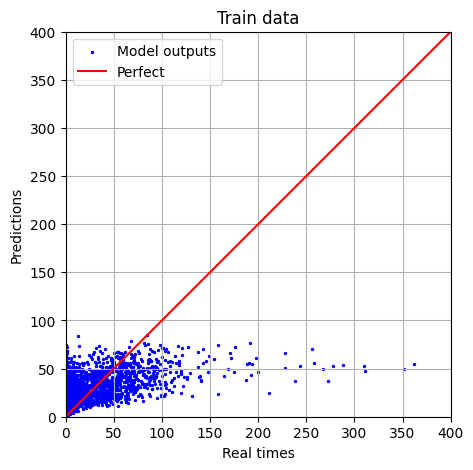

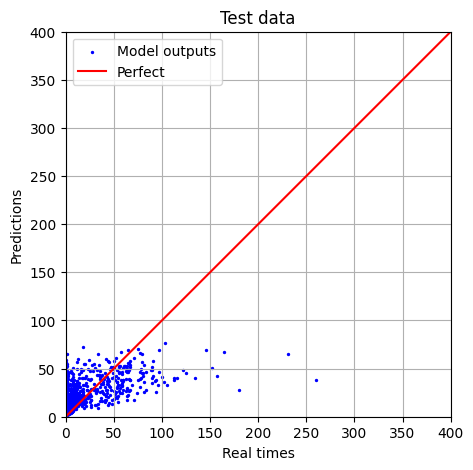

Epochs:  90%|████████▉ | 896/1000 [32:29<03:55,  2.27s/it]

Epochs:  90%|█████████ | 900/1000 [32:37<03:34,  2.15s/it]

Train Loss: 719.921936
Test MSE = 807.4673461914062
Test L1 = 11.791912078857422
Test R2 = -0.20802736282348633
Test MAPE = 12.552797317504883
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  91%|█████████ | 909/1000 [32:55<03:03,  2.01s/it]

New best: 910, Train Loss: 413.600739
Test MSE = 488.9366149902344
Test L1 = 8.65843391418457
Test R2 = 0.2685168385505676
Test MAPE = 12.489500045776367
Test Spearman = 0.6168548464775085


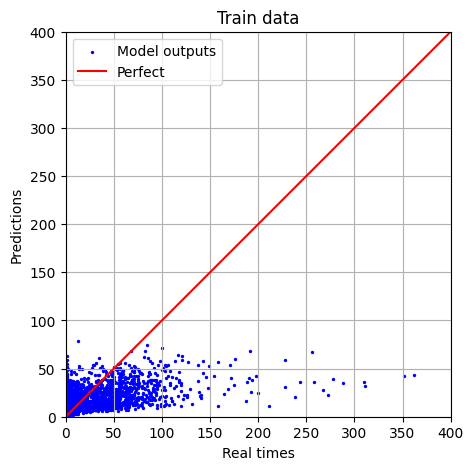

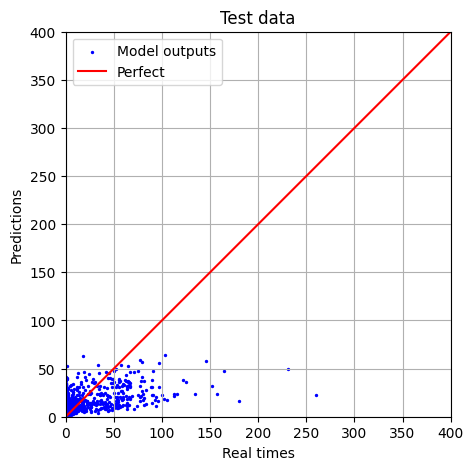

Epochs:  91%|█████████ | 910/1000 [32:58<03:22,  2.25s/it]

Train Loss: 413.600739
Test MSE = 488.9367370605469
Test L1 = 8.658434867858887
Test R2 = 0.2685166597366333
Test MAPE = 12.489500045776367
Test Spearman = 0.6168548464775085
--------------------------------------------------------------------------------


Epochs:  92%|█████████▏| 920/1000 [33:19<02:47,  2.09s/it]

Train Loss: 720.373413
Test MSE = 807.927734375
Test L1 = 11.811417579650879
Test R2 = -0.2087160348892212
Test MAPE = 12.653719902038574
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  93%|█████████▎| 930/1000 [33:39<02:28,  2.12s/it]

Train Loss: 718.775574
Test MSE = 806.299560546875
Test L1 = 11.807036399841309
Test R2 = -0.20628023147583008
Test MAPE = 12.709022521972656
Test Spearman = 0.3468434512615204
--------------------------------------------------------------------------------


Epochs:  94%|█████████▍| 940/1000 [34:00<02:05,  2.09s/it]

Train Loss: 720.680359
Test MSE = 808.2405395507812
Test L1 = 11.824651718139648
Test R2 = -0.20918405055999756
Test MAPE = 12.722199440002441
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  95%|█████████▌| 950/1000 [34:20<01:44,  2.09s/it]

Train Loss: 720.873352
Test MSE = 808.4374389648438
Test L1 = 11.832972526550293
Test R2 = -0.20947861671447754
Test MAPE = 12.765254974365234
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  96%|█████████▌| 960/1000 [34:40<01:23,  2.09s/it]

Train Loss: 721.137939
Test MSE = 808.7070922851562
Test L1 = 11.844362258911133
Test R2 = -0.20988202095031738
Test MAPE = 12.824187278747559
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  97%|█████████▋| 970/1000 [35:01<01:02,  2.09s/it]

Train Loss: 679.594116
Test MSE = 766.3684692382812
Test L1 = 11.01938533782959
Test R2 = -0.14654052257537842
Test MAPE = 11.944369316101074
Test Spearman = 0.6106178164482117
--------------------------------------------------------------------------------


Epochs:  98%|█████████▊| 980/1000 [35:21<00:41,  2.09s/it]

Train Loss: 721.545959
Test MSE = 809.123046875
Test L1 = 11.861909866333008
Test R2 = -0.21050429344177246
Test MAPE = 12.91497802734375
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------


Epochs:  99%|█████████▉| 990/1000 [35:42<00:20,  2.09s/it]

Train Loss: 544.504700
Test MSE = 626.7456665039062
Test L1 = 8.561885833740234
Test R2 = 0.06234496831893921
Test MAPE = 6.802356243133545
Test Spearman = 0.6184308528900146
--------------------------------------------------------------------------------


Epochs: 100%|██████████| 1000/1000 [36:02<00:00,  2.16s/it]

Train Loss: 721.985352
Test MSE = 809.5709838867188
Test L1 = 11.880775451660156
Test R2 = -0.21117448806762695
Test MAPE = 13.012591361999512
Test Spearman = 1.1271352917674449e-07
--------------------------------------------------------------------------------
Best result is 413.6007385253906 at 910


Test MSE = 488.936767578125
Test L1 = 8.65843391418457
Test R2 = 0.2685166001319885
Test MAPE = 12.489498138427734
Test Spearman = 0.616856038570404
Best result is 413.6007385253906 at 910


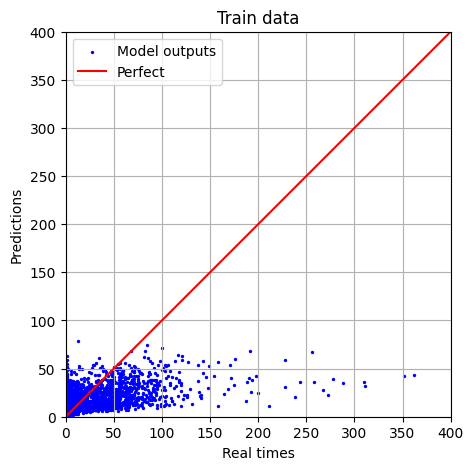

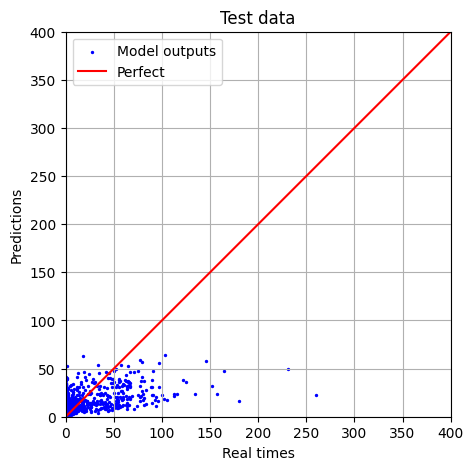

In [ ]:
torch.manual_seed(12345)
random.seed(12345)
numpy.random.seed(12345)

# Initialize model 
model = GCN(hidden_dim=config['embedding']).to(DEVICE) 
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
if config['target'] == "sat":
    criterion = torch.nn.BCELoss() # only 2 classes 
else:
    criterion = torch.nn.MSELoss() 


# Save model configuration 
timestamp = int(time.time()) 
os.mkdir(f"logs/{timestamp}")
with open(f"logs/{timestamp}/config.txt", 'w') as f:
    for key in config:
        f.write(f'{key}={config[key]}\n') 

# Before training (evaluate initial random model)
train_out, train_y = test(train_loader) 
test_out, test_y = test(test_loader) 
# Return to linear-space 
if config['log']:
    train_out = torch.exp(train_out)
    train_y = torch.exp(train_y)
    test_out = torch.exp(test_out)
    test_y = torch.exp(test_y) 

train_loss = compute_main_metric(train_out, train_y) 
metrics = compute_metrics(test_out, test_y) 
for metric in metrics:
    print(f'Test {metric} = {metrics[metric]}') 

# Store in files 
with open(f"logs/{timestamp}/init-metrics.txt", 'w') as f:
    for metric in metrics:
        f.write(f'Test {metric} = {metrics[metric]}\n') 
    if config['target'] == 'seconds':
        # For regression 
        f.write(f"{train_loss} & {metrics['MSE']} & {metrics['L1']} & {metrics['R2']} & {metrics['MAPE']} & {metrics['Spearman']}\n")
plot_predictions(train_out, train_y, title='Train data', file=f'logs/{timestamp}/init-train.png') 
plot_predictions(test_out, test_y, title='Test data', file=f'logs/{timestamp}/init-test.png') 




# Actual training 
best_loss = 1e10 
best_epoch = 0 
best_model = deepcopy(model) 
history = {}
for epoch in tqdm(range(1, config['epochs']+1), desc='Epochs'): 
    train() 
    train_out, train_y = test(train_loader) 
    train_loss = compute_main_metric(train_out, train_y) 

    # Save best model so far 
    if train_loss < best_loss:
        best_loss = train_loss 
        best_model = deepcopy(model) 
        best_epoch = epoch 

        print(f'New best: {epoch:03d}, Train Loss: {train_loss:.6f}') 

        test_out, test_y = test(test_loader) 
        # Return to linear-space 
        if config['log']:
            train_out = torch.exp(train_out)
            train_y = torch.exp(train_y)
            test_out = torch.exp(test_out)
            test_y = torch.exp(test_y) 

        metrics = compute_metrics(test_out, test_y) 
        for metric in metrics:
            print(f'Test {metric} = {metrics[metric]}') 
        
        plot_predictions(train_out, train_y, title='Train data') 
        plot_predictions(test_out, test_y, title='Test data') 
        print() # Empty line 

        history[epoch] = {
            "train_loss": train_loss.cpu().item()
        }
        history[epoch].update({ k: metrics[k].cpu().item() for k in metrics }) 
        

    if epoch % 10 == 0:
        test_out, test_y = test(test_loader) 
        metrics = compute_metrics(test_out, test_y) 
        print(f'Train Loss: {train_loss:.6f}') 
        for metric in metrics:
            print(f'Test {metric} = {metrics[metric]}') 
        print("-"*80)

print(f"Best result is {best_loss} at {best_epoch}") 



# After training
model = best_model # Evaluate the best model 
train_out, train_y = test(train_loader) 
test_out, test_y = test(test_loader) 
# Return to linear-space 
if config['log']:
    train_out = torch.exp(train_out)
    train_y = torch.exp(train_y)
    test_out = torch.exp(test_out)
    test_y = torch.exp(test_y) 

train_loss = compute_main_metric(train_out, train_y) 
metrics = compute_metrics(test_out, test_y) 
for metric in metrics:
    print(f'Test {metric} = {metrics[metric]}') 

# Store in files 
with open(f"logs/{timestamp}/metrics.txt", 'w') as f:
    f.write(f"Train loss: {train_loss} at {best_epoch}\n")
    for metric in metrics:
        f.write(f'Test {metric} = {metrics[metric]}\n') 
    if config['target'] == 'seconds':
        # For regression 
        f.write(f"{best_epoch} & {train_loss} & {metrics['MSE']} & {metrics['L1']} & {metrics['R2']} & {metrics['MAPE']} & {metrics['Spearman']}\n")
plot_predictions(train_out, train_y, title='Train data', file=f'logs/{timestamp}/train.png') 
plot_predictions(test_out, test_y, title='Test data', file=f'logs/{timestamp}/test.png') 

with open(f"logs/{timestamp}/architecture.txt", 'w') as f:
    for batch in train_loader:
        batch = batch.to(DEVICE)
        f.write(summary(model, batch, max_depth=5)) 
        break 
# Store best model 
torch.save(best_model, f"logs/{timestamp}/model.pt") 


t_end = int(time.time()) 
with open(f"logs/{timestamp}/time.txt", 'w') as f:
    f.write(f"{t_end - timestamp}") # in seconds

df_history = pd.DataFrame([history[k] for k in sorted(history.keys())], index=sorted(history.keys())) 
df_history.to_csv(f"logs/{timestamp}/history.csv", index_label="Epoch") 

print(f"Best result is {best_loss} at {best_epoch}")